<a href="https://colab.research.google.com/github/makagan/TRISEP_Tutorial/blob/main/Exercises/1.1.Fitting-and-Bias-Variance-Tradeoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Fitting and Exploring the Bias Variance Tradeoff

Adapted from [notebooks](https://github.com/odsl-team/block-course-apr24-ML/tree/main/Exercises) developed by Nicole Hartman and Lukas Heinrich


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

## Step 1: Write a function `generate_data(N)`

Write a function `generate_data(N)` that produces `N` samples from the following model:

$$
p(s) = p(x,y) = p(y|x)p(x)
$$

with the following "true" underlying polynomial noisy model

$$p(x) = \mathrm{Uniform}(-1,1)$$
$$p(y|x) = \mathrm{Normal}(\mu = f(x),\sigma = 0.2)$$
$$f(x) = \sum_i p_i x^i$$,

with $p_0 = -0.7, p_1 = 2.2, p_2 = 0.5, p_3 = 1.0$

Hint: you can use `np.polyval` to evaluate a polynomial with a fixed set of coefficients (but watch out for the order)

The function should return a array of `x` values and an array of `y` values

In [31]:
coeffs_true = [1.0,0.5,2.2,-0.7]

def generate_data(N: int) -> tuple[np.array,np.array]:
  x = np.sort(np.random.uniform(-1,1,N))
  y = np.random.normal(np.polyval(coeffs_true,x),0.2)
  return x,y

## Step 2: Plot Samples and Functions

Write a function `plot(ax, train_x, train_y, p_trained, p_true)` that
takes a matplotlib axis object and plots

* plot the true function
* plot a second (trained or random) function
* plot the samples

In [34]:
def plot(ax, train_x, train_y, p_trained, p_true,**kwargs) -> None:
  ax.scatter(train_x,np.polyval(p_true,train_x),label='true',**kwargs)
  ax.scatter(train_x,np.polyval(p_trained,train_x),label='trained',**kwargs)
  ax.scatter(train_x,train_y,label='samples',**kwargs)
  ax.legend()

Check your function:

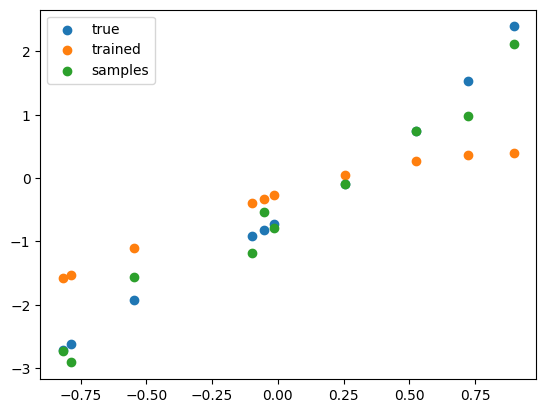

In [35]:
f = plt.figure()
x,y = generate_data(10)
plot(f.gca(),x,y,np.random.normal(size = (4,)), coeffs_true)

## Step 3

One can show that given a Hypothesis Set of Polynomial functions

$$f(x) = \sum_i w_i x^i$$

and a risk function of the following form

$$l(s) = l(x,y) = (y - f(x))^2$$

there is a closed form solution for finding the empirical risk minimization, where the best fit coefficients $\vec{w}$ is given by

$$
w = (X^T X)^{-1} X^T y
$$

where $X$ is the matrix with rows $x = (x_0,x_1,x_2,x_3,\dots,x_d)$ and one row for each sample

$$
X = \left(
\begin{array}{}
x_0^{(1)},\dots,x_d^{(1)}  \\
x_0^{(2)},\dots,x_d^{(2)}  \\
\dots \\
x_0^{(n)},\dots,x_d^{(n)}  \\
\end{array}
\right)
$$

* Write a function `learn(train_x, train_y, degree)` to return the $(d+1)$ optimal coefficients for a polynomial fit of degree $d$.
* Fit a sampled of 5 data points with degree 4
* Plot the Trained function together with the true function using the plotting method from the last step
* Try this multiple time to get a feel for how much the data affects the fit
* Try degree 1 and observe how the trained function is much less sensitive to the data

In [38]:
def learn(train_x, train_y, degree):
  #X = np.array()

  coeffs = None

  raise NotImplementedError

  return coeffs

In [ ]:
x,y = generate_data(5)
coeffs_train = learn(x,y,4)
f = plt.figure()
plot(f.gca(),x,y,coeffs_train, coeffs_true)

In [ ]:
x,y = generate_data(5)
coeffs_train = learn(x,y,1)
f = plt.figure()
plot(f.gca(),x,y,coeffs_train, coeffs_true)

## Step 4

Write a function to evaluate the risk or loss of a sample. Use our loss function for which we have the training procedure above

$$
l(s) = l(x,y) = (f(x) - y)^2
$$

and right a function `risk(x,y_true, trained_coeffs)` to compute

$$
\hat{L} = \frac{1}{N}\sum_i l(s_i) = \frac{1}{N}\sum_i l(x^{(i)},y^{(i)}) = \frac{1}{N}\sum_i ( f(x^{(i)}) - y^{(i)})^2
$$

* Draw a size 10 data sample and fit the result to obtain trained coefficients
* Draw 10000 samples of size 10 and compute their empirical risk under the trained coefficients
* Repeat the same but use the true coefficients of the underlying data-generating process
* Histogram the two sets of 10,000 risk evaluations. Which one has lower average risk?

In [ ]:
def risk(x, y_true, p):
    raise NotImplementedError

## Step 5

Explore how the fit improves when adding more data. Plot the best fit model for data set sizes of

$$N = 5,10,100,200,1000$$

## Step 6

Explore how the fit changes when using more and more complex models. Plot the best fit model for degrees

$$d = 1,2,5,10$$

## Step 7 Bias-Variance Tradeoff

Draw two datasets:

* A train dataset with $N=10$
* A test dataset with $N=1000$

Perform trainings on the train dataset for degrees $1\dots8$ and store the training coefficients

* Evaluate the risk under the various trainings for the train and the test dataset
* Plot the train and test risk as a function of the polynomial degree